# 14.2 Exercises

## The Dataset

The code below already loads the dataset and the packages we use today. The `Oxboys` dataset consists of longitudinal height measurements for boys from Oxford, UK. Our goal for today is to predict `height` by `age`. The dataset contains the following variables:

- `Subject` - Unique identifier for each child in the experiment
- `age` - The standardized age 
- `height` - The height of the child in centimeters
- `Occasion` - The result of converting age from a continuous variable to a categorical one (can be ignored)

In [1]:
# Load packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

data = sm.datasets.get_rdataset("Oxboys", "nlme").data
data

,Subject,age,height,Occasion
0,1,-1.0000,140.5,1
1,1,-0.7479,143.4,2
2,1,-0.4630,144.8,3
3,1,-0.1643,147.1,4
4,1,-0.0027,147.7,5
...,...,...,...,...
229,26,-0.0027,138.4,5
230,26,0.2466,138.9,6
231,26,0.5562,141.8,7
232,26,0.7781,142.6,8


## Exercise 1: Data visualization

To get a better feeling for the data, create two plots:

- Plot 1: Scatterplot with a single regression line for `height` predicted by `age`
- Plot 2: Scatterplot with a regression line for each subject for `height` predicted by `age`.

Inspect the plots. Do you think multilevel modeling is needed for this data?

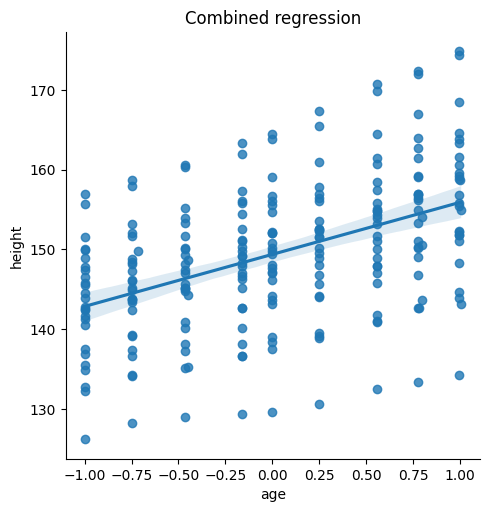

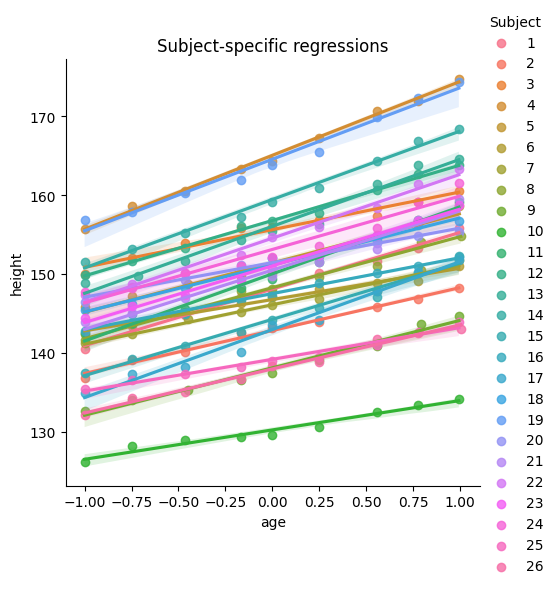

In [2]:
sns.lmplot(x='age', y='height', data=data)
plt.title("Combined regression")

sns.lmplot(x='age', y='height', hue='Subject', data=data)
plt.title("Subject-specific regressions");

## Exercise 2: Fitting a null model

To find out how much variance in `height` is explained by `Subject` we begin by fitting a null model without any predictors. Set up the model and inspect the model output. To further analyze the data, calculate the ICC and interpret it. Which model parameter indicates the amount of variance in the intercept?

In [3]:
def calculate_icc(results):
    icc = results.cov_re / (results.cov_re + results.scale)
    
    return icc.values[0, 0]

model1 = smf.mixedlm("height ~ 1", data, groups=data["Subject"])
model1_fit = model1.fit(method="bfgs")

print(model1_fit.summary())

icc = calculate_icc(model1_fit)
print("The ICC IS:", icc)

# The `Group Var` row in the output show the variance of the intercept.
# 74.45% of the variance in `height` is explained by `Subject`. 

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: height   
No. Observations: 234     Method:             REML     
No. Groups:       26      Scale:              21.7271  
Min. group size:  9       Log-Likelihood:     -733.2949
Max. group size:  9       Converged:          Yes      
Mean group size:  9.0                                  
-------------------------------------------------------
           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------
Intercept 149.519    1.590 94.039 0.000 146.403 152.636
Group Var  63.314    4.221                             

The ICC IS: 0.7445117769323151


## Exercise 3: Fitting a random intercept model

As seen in the null model, there is a lot of variance explained by the grouping variable `Subject`. Therefore, fitting one regression over all datapoints may lead to wrong interpretations and we need the model to account for inter-individual differences. To do so, please fit a random intercept model, predicting `height` with `age`. What is the average relationship between `age` and `height`?

In [4]:
model2 = smf.mixedlm("height ~ age", data, groups=data["Subject"])
model2_fit = model2.fit(method="bfgs")

print(model2_fit.summary())

# The average relationship between `age` and `height` is 0.717. For a one-unit (i.e. 1SD) increase in `age`, `height` is expected to increase by 0.717 SDs.

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: height   
No. Observations: 234     Method:             REML     
No. Groups:       26      Scale:              1.7181   
Min. group size:  9       Log-Likelihood:     -470.0148
Max. group size:  9       Converged:          Yes      
Mean group size:  9.0                                  
-------------------------------------------------------
           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------
Intercept 149.372    1.590 93.934 0.000 146.255 152.488
age         6.524    0.133 49.228 0.000   6.264   6.784
Group Var  65.554   15.019                             



## Exercise 4: Fitting a random intercept & random slope model

To increase the flexibility in our model, we will now add random slopes as well, meaning that for every subject a random intecept and a random slope is fitted. Please specify the model and interpret the output.

In [5]:
model3 = smf.mixedlm("height ~ age", data, groups=data["Subject"], re_formula="~age")
model3_fit = model3.fit(method="bfgs")

print(model3_fit.summary())

# The variance of the slope is 0.034, indicating that all subjects have very similar slopes (hence, there is very little variance). 
# The correlation between slope and intercept is 0.105, meaning subjects with a larger intercept tend to have a more positive/steeper slope.

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   height   
No. Observations:   234       Method:               REML     
No. Groups:         26        Scale:                0.4355   
Min. group size:    9         Log-Likelihood:       -362.0455
Max. group size:    9         Converged:            Yes      
Mean group size:    9.0                                      
-------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept       149.372    1.585 94.217 0.000 146.264 152.479
age               6.525    0.336 19.404 0.000   5.866   7.185
Group Var        65.303   29.873                             
Group x age Cov   8.710    5.151                             
age Var           2.825    1.344                             



## Voluntary exercise 1: Fitting a random slope & fixed intercept model

Until now we either looked at random intercept - fixed slope models (only the intercepts vary accross subject) or at random intercept - random slope moddels (intercept and slope vary accross subects). However, it is also possible to fit fixed intercept & random slope models. Find out how to do it and specify such a model. What is different compared to the random intercept & random slope model?

**Important information:** There might be some warnings which refer to the model not converging. This is probably caused by the low variance in the slope (see above). The random effects in the model have very small or zero variance, indicating that the random effect might not be necessary or is poorly estimated. For now, you can ignore this warning. However, you should be extremely cautious when interpreting model estimates in case of convergence problems.

In [7]:
model4 = smf.mixedlm("height ~ age", data, groups=data["Subject"], re_formula="~age - 1")
model4_fit = model4.fit(method="bfgs")

print(model4_fit.summary())
# The is no estimate for the intercept variance. This is because we specified the intercept to be fixed.
# Consequently, there is also no estimate for the correlation between intercept and slope.

                  Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        height 
No. Observations:        234            Method:                    REML   
No. Groups:              26             Scale:                     63.6450
Min. group size:         9              Log-Likelihood:            inf    
Max. group size:         9              Converged:                 Yes    
Mean group size:         9.0                                              
--------------------------------------------------------------------------
           Coef.     Std.Err.      z    P>|z|     [0.025         0.975]   
--------------------------------------------------------------------------
Intercept 149.372         0.522 286.238 0.000        148.349       150.395
age         0.000 166157102.805   0.000 1.000 -325661937.274 325661937.274
age Var     0.000                                                         



/home/mibur/miniconda3/envs/psy111/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/mibur/miniconda3/envs/psy111/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/mibur/miniconda3/envs/psy111/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/mibur/miniconda3/envs/psy111/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/mibur/miniconda3/envs/psy111/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the e